In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
import IPython.display

2023-04-14 17:23:09.156552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option("display.max_row", 200)

In [3]:
df = pd.read_csv("data/all_data_aggr_nonan.csv", index_col=0)

In [4]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
              'activity', 'screen', 'call', 'sms', 'appCat.builtin',
              'appCat.communication', 'appCat.entertainment', 'appCat.finance',
              'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
              'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days'  # always correct
IN_STEPS = 7  # use 7 days
OUT_STEPS = 1  # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

In [5]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

test_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)

test_window.update_datasets(train_series, val_series, test_series, norm=False)

2023-04-14 17:23:13.219182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
a, b = test_window.example


In [7]:
lstm_model_classifier = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

MAX_EPOCHS = 5

In [8]:
def compile_and_fit_classifier(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    # model.compile(loss=tf.keras.losses.MeanSquaredError(),
    #               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
    #               metrics=[tf.keras.metrics.MeanAbsoluteError()])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [9]:
history = compile_and_fit_classifier(lstm_model_classifier, test_window)
val_performance = {}
performance = {}

probs = lstm_model_classifier.predict(test_window.val)
preds = probs.argmax(axis=-1)
val_performance['LSTM'] = lstm_model_classifier.evaluate(test_window.val, verbose=0)

probs = lstm_model_classifier.predict(test_window.test)
preds = probs.argmax(axis=-1)
performance['LSTM'] = lstm_model_classifier.evaluate(test_window.test, verbose=0)

Epoch 1/5
105/105 [==============================] - 10s 43ms/step - loss: 1.4723 - sparse_categorical_accuracy: 0.2509 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.5961
Epoch 2/5
105/105 [==============================] - 5s 37ms/step - loss: 1.1425 - sparse_categorical_accuracy: 0.3106 - val_loss: 0.9339 - val_sparse_categorical_accuracy: 0.6243
Epoch 3/5
105/105 [==============================] - 3s 20ms/step - loss: 1.1168 - sparse_categorical_accuracy: 0.3226 - val_loss: 0.9482 - val_sparse_categorical_accuracy: 0.6261
Epoch 4/5
68/68 [==============================] - 1s 4ms/step


In [10]:
print("The accuracy on the test set is:",round(performance["LSTM"][1], 4))

The accuracy on the test set is: 0.7407


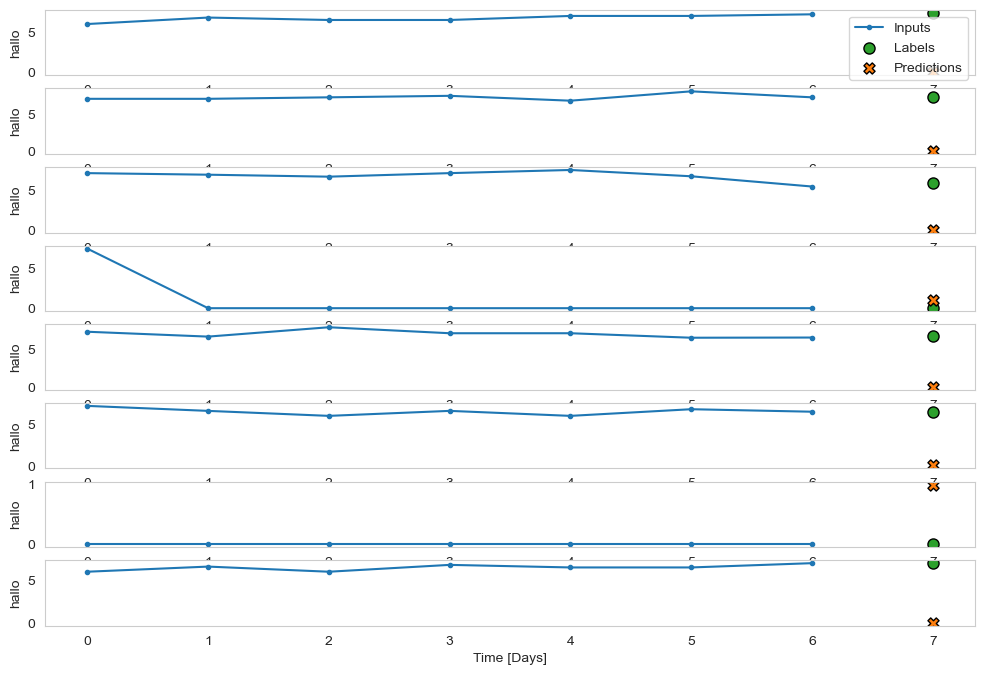

In [11]:
test_window.plot(lstm_model_classifier, single=True, max_subplots=100, y_lab="hallo")

In [35]:
def plot(self, model=None, plot_col=None, max_subplots=3, single=False):
        inputs, labels = self.example
        if not plot_col:
            plot_col = self.LABELS[0]
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"")
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                if single:
                    values = float(predictions[n, label_col_index])
                    x_values = self.label_indices[-1]
                else:
                    values = predictions[n, :, label_col_index]
                    x_values = self.label_indices

                plt.scatter(x_values, values+7,
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [Days]')
        plt.show()

In [36]:
a, b = test_window.example
lstm_model_classifier(a)[0]*10

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.3434505 , 0.01807595, 0.0094404 , 0.02044987, 0.12058669,
       0.31599107, 4.2608137 , 3.9097786 , 0.962882  , 0.03853041],
      dtype=float32)>

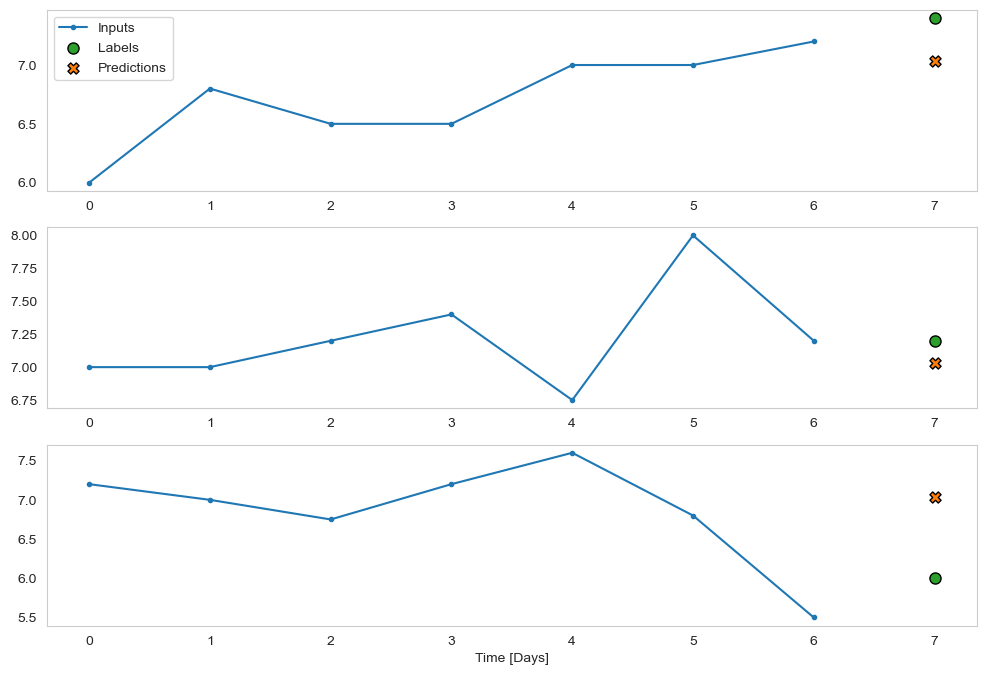

In [37]:
plot(test_window, lstm_model_classifier, single=True)